# Language Identification - A statistical approach

**Implementation of relative entropy for language identification** <br>
Author: Anne-Sophie Karmel <br>
Date: 15/04/2020
<br>
## Goal
The goal is to develop an algorithm that detect the language of an arbitrary text (sentences or more lengthy texts). <br>
For example, the algorithm should return “en” for the English sentence “I am currently
eating my breakfast”, or “fr” for the French sentence “J’ai oublié mon parapluie dans l’abribus”.

## Approach

The model used is based on the working paper ["Language identification: Examining the issues"](http://localhost:8888/files/resources/StatisticalLID-II.pdf) by Penelope Sibun and Jeffrey C. Reynar (1996).
<br><br>
The approach to language identification uses relative entropy, also known as Kullback Leibler distance. <br>
The relative entropy between two probability distributions reflects the amount of additional information necessary to encode the second distribution using an optimal code generated for the first distribution. <br>
Practically it is a useful measure of the similarity between probability distributions. Relative entropy ranges from $0$ to $\infty$ with the minimum generated when the two distributions are identical.<br>
<br>
**The equation for the relative entropy:**
<br><br>
$\displaystyle{D(p \Vert q) = \sum_{x \in \chi} p(x) \cdot log \frac{p(x)}{q(x)}}$
<br><br>

A dataset is provided containing sentences in 21 languages (named “formatted_data”).<br> 
This database is a .csv files whose separator is a “;”. The first column is
the language code, the second one is the text, and the third one is the number of characters in the specified language. <br>
This database is a collection of texts extracted from the European Union Proceedings.
<br>

## Application

To apply relative entropy to language identification, we use a portion of the subset of a coprus associated with a particular language as a training set. The selection is performed randomly. This is done for each of the languages being discriminated.
<br>
For each training set, a probability distribution is generated by first counting particular events, such as character unigrams, bigrams or trigrams. 
<br>
Smoothing ensures that events found in the test data but not in the training data do not cause the relative entropy score to become $\infty$. Here we choose to apply *Laplace smoothing* (see below).
<br>
These counts are converted to probabilities using the *relative frequency* technique (see below).
<br><br>
Test data, which are constrained to not overlap with the training data, are also selected randomly. For each of the test sets, a probability distribution is generated in the same manner without smoothing step.<br>
<br>
Lastly, every test set is assigned the language which minimizes the relative entropy between the proability distribution of the given test set and the distribution associated with the training set for that language.
<br> Let $p$ be the distribution associated with the test set $P$ and $q_{i}$ be the distribtion associated with training set $Q_{i}$, whose language is $L(Q_{i})$. Assume the training sets are numebered $1$ to $n$. <br><br>We assign:
<br>
<br>
$\displaystyle{L(P)=L(Q_{x})}$ 
<br><br>where $x=arg min_{1\leq i \leq n}D(p\Vert q_{i})$

## Expected results
- Correct implementation of the proposed model or another of your choice
- Good code quality (comments, overall clarity)
- An assessment of model performances and several ways to improve it
- Highlighting the limits of your model
- A live demo of your code running on sentences examples (we can do it on Skype)
- discussion about your work (Skype also)
- A very short “report” detailing your approach. 

## Implementation

In [468]:
# Import useful libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import seaborn as sns

In [469]:
# Loading the data 
data = pd.read_csv('../data/formatted_data.csv',sep=';')
data.head()

,language,text,length_text
0,bg,Състав на Парламента: вж. протоколиОдобряване ...,327263
1,cs,Schválení zápisu z předchozího zasedání: viz z...,317927
2,da,Genoptagelse af sessionenJeg erklærer Europa-P...,678400
3,de,Wiederaufnahme der SitzungsperiodeIch erkläre ...,747690
4,el,Επαvάληψη της συvσδoυΚηρύσσω την επανάληψη της...,523277


In [470]:
# Check if the dataset has any missing values and contains the expected number of languages
print(f"Number of languages in the dataset: {data['language'].value_counts().sum()}")
print(f"Number of missing values in the dataset:\n{data.isna().sum()}")

Number of languages in the dataset: 21
Number of missing values in the dataset:
language       0
text           0
length_text    0
dtype: int64


[]

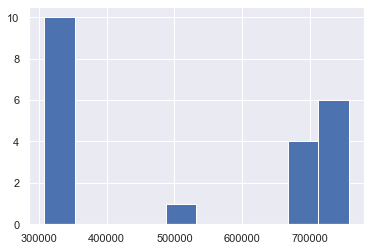

In [471]:
# Verify the distribution of text lengths accross the dataset
data.length_text.hist().plot()

To adjust the training and test set sizes for each language we will set the size to a percentage of the corpus for the language. 

In [472]:
# Create randomly training sets and test sets for each language
# The test size as a percentage (p) of the dataset for a given language is 
# given as a parameter for future model tuning

def split_training_test(df, p, seed):
    '''Split randomly a dataframe df into training set (1-p in %) and test set (p in %)
       Return training and test dataframes
    '''
    
    random_idx = []
    test = pd.DataFrame()
    training = pd.DataFrame()
    
    # initialise the seed
    np.random.seed(seed)
   
    # define random value for first index of the test size that is between 0 and length_text-test_size-1
    test_size = (df['length_text']*p).astype('int')
    random_idx = np.random.randint(0,df['length_text']-test_size)
    
    # assign test set with test_size of characters randomly picked into the text
    test['language'] = df['language'].copy()
    test['text'] = df.apply(lambda row:row['text'][random_idx[row.name]:random_idx[row.name]+test_size[row.name]],axis=1) 
    test['length_text'] = test_size
    
    # assign training set with remaining characters from the text
    training['language'] = df['language'].copy()
    training['text'] = df.apply(lambda row:row['text'][:random_idx[row.name]-1]+row['text'][random_idx[row.name]+test_size[row.name]:], axis=1) 
    training['length_text'] = df.apply(lambda row:row['length_text']-test_size[row.name], axis=1) 
    
    return training, test


In [473]:
# Create training and test sets
df_training, df_test = split_training_test(data, .2, 0)

df_test.head()

,language,text,length_text
0,bg,"овакия и България със санкции, а дори чухме, ч...",65452
1,cs,viz zápisPřerušení zasedáníDichiaro interrotta...,63585
2,da,"orbindelse over det arbejde, der er blevet udf...",135680
3,de,"en, die sich in großen Teilen mit Ihrer eigene...",149538
4,el,"του ιδιωτικού τομέα, των κοινωνικών εταίρων, τ...",104655


### Estimate n-gram probability distributions

To compute the probability (maximum likelihood estimate) of a n-gram, we will use the *relative frequency formula*: 
<br><br>
$\displaystyle{p_{ML}(\omega_{a}) = \frac{c(\omega_{a})}{N}}$
<br><br>where:
    * $p_{ML}(\omega_{a})$ is the maximum likelihood estimate of event $\omega_{a}$, the n-gram,
    * $c(x)$ is the counting function of the event x,
    * $N$ is the total number of events (n-gram) in the corpus set.      
<br><br>
**Formula for bigram**: 
<br><br>
$\displaystyle{p_{ML}(\omega_{a}|\omega_{b}) = \frac{c(\omega_{a},\omega_{b})}{\sum_{\omega_{b}}c(\omega_{a},\omega_{b})}\approx \frac{c(\omega_{a},\omega_{b})}{c(\omega_{a})}}$
<br><br>where:<br>
* $p_{ML}(\omega_{a})$ is the maximum likelihood estimate of event $\omega_{a}$, the bigram,
* $c(x)$ is the counting function of the event x,
* $N$ is the total number of events (n-gram) in the corpus set.
<br>

This formula can be extended to n-gram.

### Smoothing 
When there is no occurence of the n-gram in the training sample, $c(\omega_{a})=0$, we face the folowing problems:<br>
* For unigram case, we get a zero probability, which is not satisfactory as we work on a very limited training data.
* For the bigram case, we get an undefined probability, which is even
more problematic.
Therefore we apply a smoothing technique to adjust the equation. 
<br><br>
**Laplace smoothing** has been choosen here for simplicity however the results generally observed are sub-optimal (see Improvements):
<br><br>
$\displaystyle{p(\omega_{a})=\frac{c(\omega_{a})+1}{N+V}}$
<br><br>where $V$ is the n-gram size in the corpus.
<br><br>

And for n-gram, the formula becomes:<br><br>
$\displaystyle{p(\omega_{n}|\omega_{n-1})=\frac{c(\omega_{n-1},\omega_{n})+1}{c(\omega_{n-1})+V}}$
<br><br>
As explained earlier, smoothing step will not be implemented for the test set.<br>




In [474]:
# Function for relative frequencies

def ml_unigram(df, smooth=True):
    '''Compute the estimated maximum likelihood probability of unigram in the corpus.
    Return a dataframe that contains the unigram and related probability 
    for each language'''
    
    df_temp_all_lang = pd.DataFrame()
    
    corpus = df['text']
    corpus_size = df['length_text']
    lang = df['language']
   
    # Loop on the text for each language
    for k in range(len(corpus)):
           
        # frequency of unigram
        c = {i:(corpus[k].count(i)) for i in set(corpus[k])}
       
        # Number of unique unigram in the corpus
        v = len(c.keys())
        
        # Total number of unigrams in the corpus
        n = corpus_size[k]

        # apply Laplace smoothing
        if smooth:
            p = {unigram: (freq + 1)/ (v + n) for unigram, freq in c.items()}
        else:
            p = {unigram: freq / n for unigram, freq in c.items()}
       
        # convert to DataFrame where unigram is the index
        df_temp = pd.DataFrame.from_dict(p, orient='index',columns=['proba'])
        df_temp['language'] = lang[k]
        
        # append to the master dataframe that contains all laguages
        df_temp_all_lang = df_temp_all_lang.append(df_temp)
    
    df_temp_all_lang.reset_index(inplace=True)
    df_temp_all_lang.rename(columns={'index':'ngram'}, inplace=True)
        
    return df_temp_all_lang


def count_bigram(text):
    '''Count the number of bigram in a text.
    Return a dictionnary'''
    
    bigram_freq = {}
    for i in range(len(text)-1):
        bigram = (text[i],text[i+1])
        if bigram not in bigram_freq:
            bigram_freq[bigram] = 1
        else:
            bigram_freq[bigram] += 1
    return bigram_freq     
    
def ml_bigram(df, smooth=True):
    '''Compute the estimated maximum likelihood probability of bigram in the corpus.
    Return a dataframe that contains the unigram and related probability 
    for each language'''
    
    df_temp_all_lang = pd.DataFrame()
    
    corpus = df['text']
    
    # by taking 2 character as event, we reduce the size of the corpus by 2
    corpus_size = df['length_text']
    
    lang = df['language']
    
    # Loop on the text for each language
    for k in range(len(corpus)):
           
        # frequency of unigram
        c_uni = {i:(corpus[k].count(i)) for i in set(corpus[k])}
       
        # frequency of bigram
        c_bi = count_bigram(corpus[k])
      
        # Number of unique unigram in the corpus
        v = len(c_uni.keys())
        
        # apply Laplace smoothing
        if smooth:
            p = {bigram: (freq + 1) / (c_uni[bigram[0]] + v) for bigram, freq in c_bi.items()}
        else: 
            p = {bigram: freq / c_uni[bigram[0]] for bigram, freq in c_bi.items()}
           
        # convert to DataFrame where unigram is the index
        df_temp = pd.DataFrame.from_dict(p, orient='index',columns=['proba'])
        df_temp['language'] = lang[k]
        
        # append to the master dataframe that contains all laguages
        df_temp_all_lang = df_temp_all_lang.append(df_temp)
    
    df_temp_all_lang.reset_index(inplace=True)
    df_temp_all_lang.rename(columns={'index':'ngram'}, inplace=True)
        
    return df_temp_all_lang
    

In [475]:
start_time_unigram = time.time()

# Compute the probabilities for each unigram by language
df_proba_test = ml_unigram(df_test, smooth=False)
df_proba_training = ml_unigram(df_training)

end_time_unigram = time.time()

print(f"Test set probability distribution first records:\n{df_proba_test.head()}") 
print(f"Training set probability distribution first records:\n{df_proba_training.head()}")

print(f"Computational time: {end_time_unigram - start_time_unigram:.5f} seconde(s)")

start_time_bigram = time.time()

# Compute the probabilities for each bigram by language
df_proba_test = ml_bigram(df_test, smooth=False)
df_proba_training = ml_bigram(df_training)

end_time_bigram = time.time()

print(f"Test set probability distribution first records:\n{df_proba_test.head()}") 
print(f"Training set probability distribution first records:\n{df_proba_training.head()}")

print(f"Computational time: {end_time_bigram - start_time_bigram:.5f} seconde(s)")

Test set probability distribution first records:
  ngram     proba language
0     И  0.000367       bg
1     t  0.000290       bg
2     B  0.000122       bg
3     w  0.000031       bg
4     л  0.024125       bg
Training set probability distribution first records:
  ngram     proba language
0     X  0.000023       bg
1     И  0.000714       bg
2     t  0.004740       bg
3     B  0.000439       bg
4     w  0.000420       bg
Computational time: 0.92334 seconde(s)
Test set probability distribution first records:
    ngram     proba language
0  (о, в)  0.069061       bg
1  (в, а)  0.325276       bg
2  (а, к)  0.029403       bg
3  (к, и)  0.124267       bg
4  (и, я)  0.070624       bg
Training set probability distribution first records:
    ngram     proba language
0  (С, ъ)  0.390303       bg
1  (ъ, с)  0.093023       bg
2  (с, т)  0.279020       bg
3  (т, а)  0.162923       bg
4  (а, в)  0.058292       bg
Computational time: 4.81212 seconde(s)


In [476]:
# Compute the distance with relative entropy

def relative_entropy(p_X, q_X):
    ''' Compute the relative entropy for 2 given series of probabilities that correspond
    to every n-gram of the respectively test and training corpus (p_X and q_X) for a 
    specific language'''
    
    # merge on right dataframe (training) to ignore unigram not present in training set
    df_new = pd.merge(p_X, q_X, how='inner', on='ngram', suffixes=('_p', '_q'))
      
    return sum(df_new['proba_p'] * np.log(df_new.proba_p / df_new.proba_q))
    

In [477]:
def model(df=data, epoch=1, test_size=.2, n_gram=1):
    '''Execute the model on number of epoch for n_gram. 
    Return a dataframe of details predictions and the observed accuracy in an array'''

    # List of languages to determine
    l_lang = df['language'].unique()

    res = pd.DataFrame(columns=['lang_test','lang_training','distance'])
    accuracy_mean = 0
    accuracy_std = 0
    
    accuracy = np.zeros(epoch)
    
    # Loop on Epoch
    for e in range(epoch):
        
        # initialise the seed for reproductability
        seed = e + 10 # arbitrary

        # Split training and test
        df_training, df_test = split_training_test(df, test_size, seed)

        if n_gram == 1:
            # Compute the probabilities for each unigram by language
            df_proba_test = ml_unigram(df_test, smooth=False)
            df_proba_training = ml_unigram(df_training)
    
        elif n_gram == 2:
            # Compute the probabilities for each bigram by language
            df_proba_test = ml_bigram(df_test, smooth=False)
            df_proba_training = ml_bigram(df_training)
    
        else:
            raise Exception('n_gram parameter value invalid, please choose between 1 (default) or 2')
        
        # Compute the relative entropy for each language of the test set
        for l_1 in l_lang:
            for l_2 in l_lang:
            
                d = relative_entropy(df_proba_test[df_proba_test['language']==l_1],
                      df_proba_training[df_proba_training['language']==l_2])
                res = res.append({'lang_test': l_1, 'lang_training': l_2, 'distance': d}
                             , ignore_index=True)

        prediction = pd.DataFrame(columns=['true','predict'])

        for l_1 in l_lang: 
            min_index = res[res['lang_test']==l_1]['distance'].idxmin(axis=0)
            lang_min_distance = res.iloc[min_index]['lang_training']
            prediction = prediction.append({'true': l_1, 'predict': lang_min_distance}, 
                                   ignore_index=True)     
    
        prediction['accurate'] = np.where(prediction['true'] == prediction['predict'],1,0)
        
        # Number of trials
        n_test = prediction['true'].count()
        
        # Compute the accuracy of the test
        accuracy[e] = (np.where(prediction['true'] == prediction['predict'],1,0).sum() / n_test)
    
    return res, accuracy
    

## Results

In [478]:
# Executions of the model with different variants
def predict(df=data, epoch=1, test_size=.01, n_gram=1):
    ''' Execute the model for the given parameters
    Print and return the accuracy results and the runtime'''
    
    start_time_model = time.time()
    res, accuracy = model(df, epoch, test_size, n_gram)
    end_time_model = time.time()

    print(f"Unigram on {epoch} epoch, test size = {test_size *100}% of the corpus:\n" + \
      f"\tAccuracy mean: {accuracy.mean():.2f}\n" + \
      f"\tAccuracy standard deviation: {accuracy.std():.2f}\n")
    print(f"---- Computational time: {end_time_model - start_time_model:.5f} seconde(s)\n")
    
    return accuracy, end_time_model - start_time_model

print("----- CASE 1 ------\n")
acc_1, runtime_1 = predict(epoch=1)

print("----- CASE 2 ------\n")
acc_2, runtime_2 = predict(n_gram=2)

print(f"For the same test size (1% of the corpus), " + \
      f"the runtime increases by {(runtime_2-runtime_1)/runtime_1:2f} for bigrams.\n")

print("----- CASE 3 ------\n")
acc_3, runtime_3 = predict(epoch=10, n_gram=2)



----- CASE 1 ------

Unigram on 1 epoch, test size = 1.0% of the corpus:
	Accuracy mean: 0.86
	Accuracy standard deviation: 0.00

---- Computational time: 4.39006 seconde(s)

----- CASE 2 ------

Unigram on 1 epoch, test size = 1.0% of the corpus:
	Accuracy mean: 0.71
	Accuracy standard deviation: 0.00

---- Computational time: 11.32167 seconde(s)

For the same test size (1% of the corpus), the runtime increases by 1.578932 for bigrams.

----- CASE 3 ------

Unigram on 10 epoch, test size = 1.0% of the corpus:
	Accuracy mean: 0.62
	Accuracy standard deviation: 0.04

---- Computational time: 105.05774 seconde(s)



Text(0, 0.5, 'Accuracy')

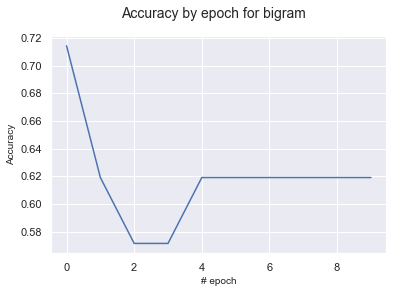

In [479]:
fig = plt.figure()
plt.plot(range(10),acc_3)
fig.suptitle('Accuracy by epoch for bigram', fontsize=14)
plt.xlabel('# epoch', fontsize=10)
plt.ylabel('Accuracy', fontsize=10)


After 4 epochs the accuracy stabilizes at 62%.

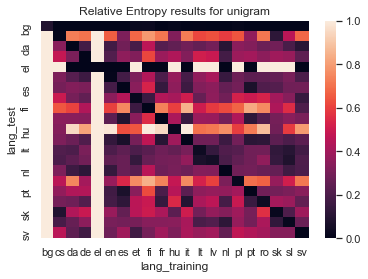

In [481]:
# Plotting the results for Unigram

res, accuracy = model(df=data, epoch=1, test_size=0.1, n_gram=1)

res_plt = res.pivot('lang_test', 'lang_training', 'distance')
sns.set()
ax = sns.heatmap(res_plt, vmin=0, vmax=1).set_title('Relative Entropy results for unigram')


We can observe that overall the language identification model is showing positive results (the diagonale numbers exhebits a distance close to 0) however some language detections perform poorly (e.g. Bulgarian or Greek).

### Take aways

1. The model is not scalable easily to bigram, the performances decline and the runtime increase.
2. The model doesn't need a large test set to achieve its best performances, hence the language identification can be done on short sentences.
3. Depending on the language syntax and alphabet we observe very diverse results.

## Limitations of the model

Despite resonable performances observed for limited training sets, the model presents some limitations:
* **Scalability**: Languages that can be dertermined need to belong to the same alphabet for the model to show good performances
* **Robustness**: When removing features (e.g. one language from the corpus), the model persormances are affected
* **Runtime performances**: The computational  effort increases with larger n-gram.


## Potential improvements
1. Increase the training data and implement a better way to split the training and test data, for example by setting a minimum length and removing all character that are irrelevant or misleading (some special character like '@', numbers, urls, etc.)
2. Pursposefully train the model on a relevant set of languages that presents sufficient inherent differences (for example English and French rather than Italian and Spanish)
3. Increase the n-gram size to increase the relative entropy between languages. The negative side will be to increase the training data and the computational power.
4. Apply better smoothing techniques or backoff or interpolation.

## Demo

In [482]:
def demo(df=data, test_text='hello world', n_gram=1):
    '''Execute the model on a test_text for n_gram. 
    Return a dataframe of details predictions, predicted language '''

    # List of languages to determine
    l_lang = df['language'].unique()

    res = pd.DataFrame(columns=['lang_test','lang_training','distance'])
    accuracy_mean = 0
    accuracy_std = 0
    
         
    # Split training and test (to reuse the same function, however the test set is empty)
    df_training = df.copy()
    
    #reinitialisation of the test set
    df_test = pd.DataFrame([{'language':'ukn', 'text':test_text, 'length_text':len(test_text)}])    
    if n_gram == 1:
        # Compute the probabilities for each unigram by language
        df_proba_test = ml_unigram(df_test, smooth=False)
        df_proba_training = ml_unigram(df_training)
    
    elif n_gram ==2:
        # Compute the probabilities for each bigram by language
        df_proba_test = ml_bigram(df_test, smooth=False)
        df_proba_training = ml_bigram(df_training)
    
    else:
        raise Exception('n_gram parameter value invalid, please choose between 1 (default) or 2')
        
    # Compute the relative entropy 
    l_1 = 'ukn'
    for l_2 in l_lang:
        d = relative_entropy(df_proba_test[df_proba_test['language']==l_1],
                    df_proba_training[df_proba_training['language']==l_2])

        res = res.append({'lang_test': l_1, 'lang_training': l_2, 'distance': d}
                             , ignore_index=True)
      
    min_index = res['distance'].idxmin(axis=0)
    lang_min_distance = res.iloc[min_index]['lang_training']
    
    return res, lang_min_distance


In [484]:
# Text to test
test_text_en = "he works in the petrochemical industry and lives in a house in the countryside"
test_text_fr = "il travaille dans l'industrie pétrochimique et vit dans une maison à la campagne"
test_text_lv = "viņš strādā naftas ķīmijas rūpniecībā un dzīvo mājā laukos"

# Execution of the demo
start_time_model = time.time()
test_lang = 'fr'
df_results, prediction = demo(test_text=test_text_fr)
end_time_model = time.time()


print(f"Demo - Unigram :\n\tPredicted language: {prediction} - True language: {test_lang}\n")
print(f"---- Computational time: {end_time_model - start_time_model:.5f} seconde(s)\n")
print(f"Detailed results:\n{df_results}")

start_time_model = time.time()
test_lang = 'en'
df_results, prediction = demo(test_text=test_text_en)
end_time_model = time.time()


print(f"Demo - Unigram :\n\tPredicted language: {prediction} - True language: {test_lang}\n")
print(f"---- Computational time: {end_time_model - start_time_model:.5f} seconde(s)\n")
print(f"Detailed results:\n{df_results}")

start_time_model = time.time()
test_lang = 'lv'
df_results, prediction = demo(test_text=test_text_lv)
end_time_model = time.time()


print(f"Demo - Unigram :\n\tPredicted language: {prediction} - True language: {test_lang}\n")
print(f"---- Computational time: {end_time_model - start_time_model:.5f} seconde(s)\n")
print(f"Detailed results:\n{df_results}")

Demo - Unigram :
	Predicted language: fr - True language: fr

---- Computational time: 1.27448 seconde(s)

Detailed results:
   lang_test lang_training  distance
0        ukn            bg  2.544136
1        ukn            cs  0.467358
2        ukn            da  0.372959
3        ukn            de  0.371910
4        ukn            el  4.020828
5        ukn            en  0.363486
6        ukn            es  0.160506
7        ukn            et  0.367158
8        ukn            fi  0.434562
9        ukn            fr  0.139068
10       ukn            hu  0.515876
11       ukn            it  0.149806
12       ukn            lt  0.430494
13       ukn            lv  0.441717
14       ukn            nl  0.383311
15       ukn            pl  0.578193
16       ukn            pt  0.224417
17       ukn            ro  0.325504
18       ukn            sk  0.397933
19       ukn            sl  0.391674
20       ukn            sv  0.293296
Demo - Unigram :
	Predicted language: en - True language: en


### References

* ["An Empirical Study of Smoothing Techniques for Language Modeling"](https://www.aclweb.org/anthology/P96-1041.pdf) by Stanley F.Chen and Joshua Goodman (1997)
* ["Language Detection For Short Text Messages In Social Media"](https://arxiv.org/pdf/1608.08515.pdf) by Ivana Balazevi, Mikio Braun,, Klaus-Robert Muller (2016)
* ["N-gram-based text categorization"](https://www.let.rug.nl/vannoord/TextCat/textcat.pdf) by Cavnar, William B., and John M. Trenkle (1994)
